# Liver Segmentation

All of the whole slide images have regions corresponding to the organ per se and empty regions corresponding either to background or vessels (blood vessels or bile ducts). In this pipeline we will look for these organs. An optional objective will be to detect accessory vessels as well.

In [1]:
from pathlib import Path

from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import (
    binary_opening,
    disk,
    label,
    remove_small_objects,
    remove_small_holes,
)
from skimage.measure import regionprops

from gulliver.io import get_image, get_channel_from_zarr, add_labels

c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


First we should choose the image file, select the scene and make a zarr file of the array.

In [2]:
DATA_DIR = Path("../data/1-4 10x.czi")

In [3]:
image = get_image(DATA_DIR, 0)

We can use the nuclei staining channel, perform some gross blurring, and apply Otsu thresholding.

In [4]:
nuclei_channel = get_channel_from_zarr(image, channel="DAPI")

In [5]:
nuclei_channel = gaussian(nuclei_channel, 10)

In [6]:
threshold = threshold_otsu(nuclei_channel)

In [7]:
liver_masks = nuclei_channel > threshold

Now that we have a mask, we can do some opening to remove small nuclei and smooth borders. We can apply algorithms to remove holes and small objects we don't care about. Let's end with a labelling step to enumerate with an identifier each structure.

In [8]:
liver_masks = binary_opening(
    liver_masks, footprint=disk(15, decomposition="sequence")
)

In [9]:
liver_masks = remove_small_holes(liver_masks, area_threshold=10**6)

In [10]:
liver_masks = label(liver_masks)

In [11]:
liver_masks = remove_small_objects(liver_masks, min_size=40000)

In [12]:
areas = regionprops(liver_masks)

In [13]:
for area in areas:
    print(area.area)

33598407.0


We can add the processed label to the zarr file and load everything in napari.

In [14]:
add_labels(image, liver_masks, "liver")

29-Dec-23 12:33:49 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).
29-Dec-23 12:33:51 - ome_zarr.reader - WARNING  - no parent found for <ome_zarr.reader.Label object at 0x0000029F132D6690>: None


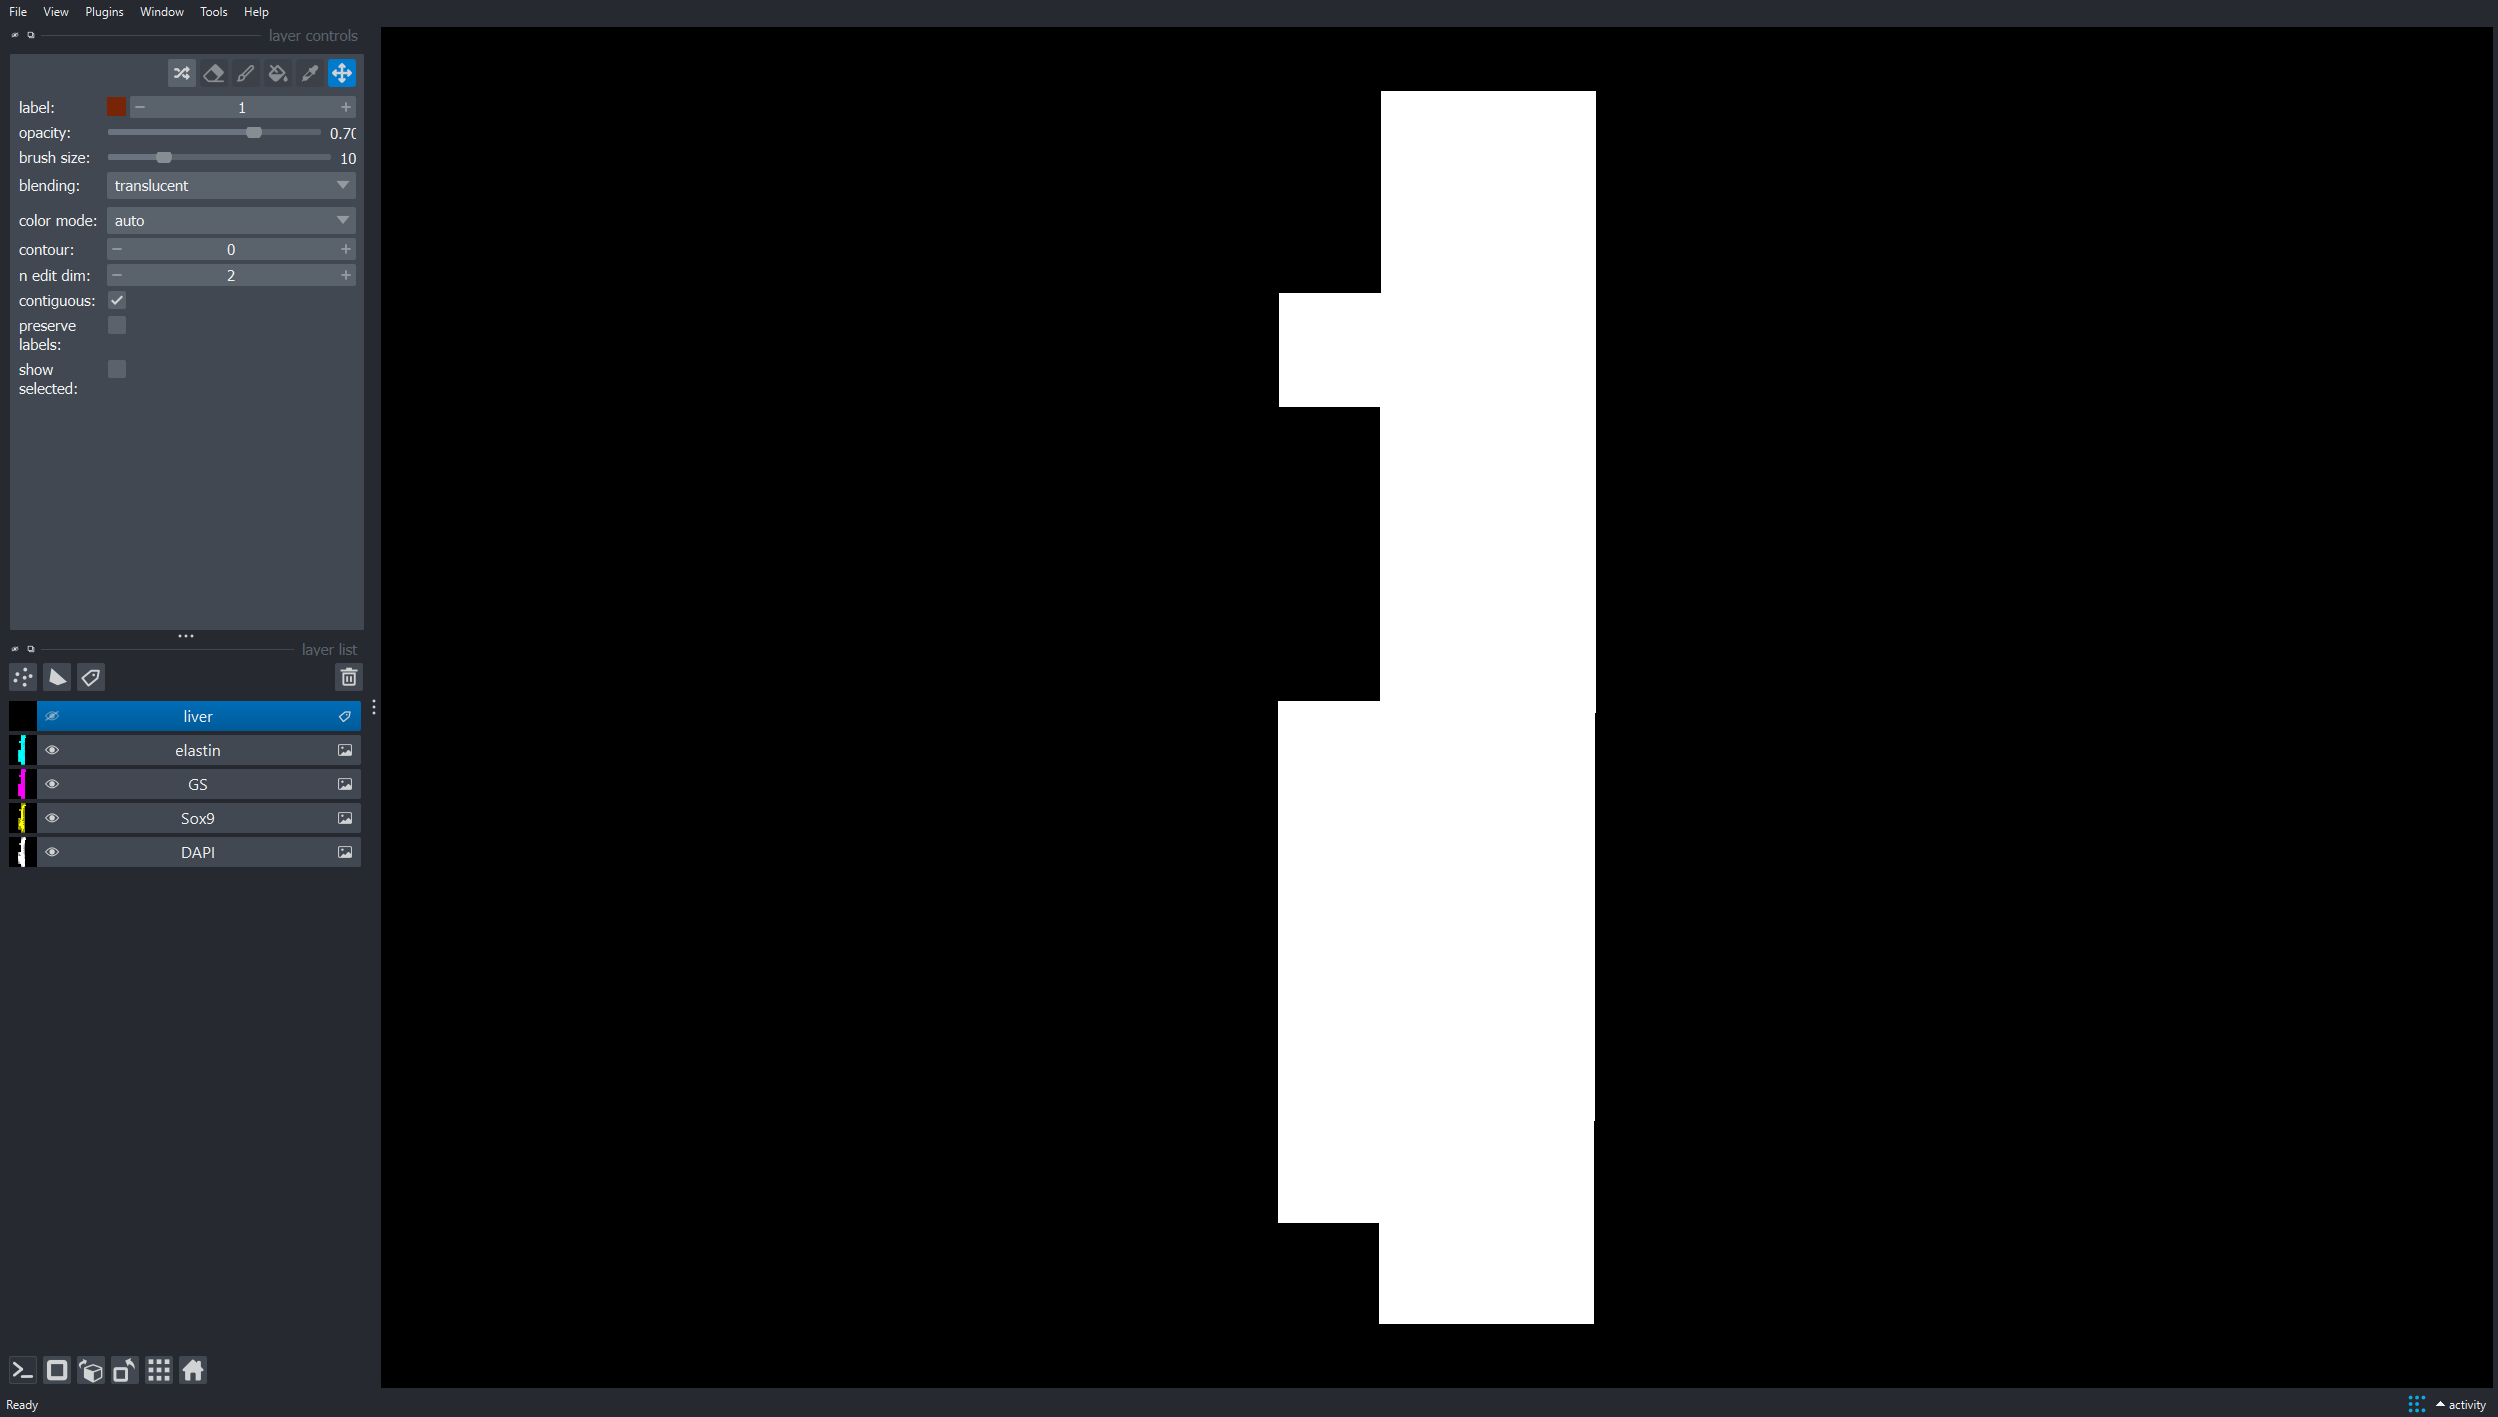

In [15]:
import napari

viewer = napari.Viewer()
viewer.open(DATA_DIR.with_suffix(".zarr"), plugin="napari-ome-zarr")
napari.utils.nbscreenshot(viewer)

The areas detected and the regions look good.